# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
import healpy as hp
import glob

# Opening HAWC Pass 5 file

In [2]:
pass5file = 'pass5.1/2.63_3.45e-11_1000000_35_1.0_combined_rec.root'

with uproot.open(pass5file) as file:
    t = file['XCDF']
    t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.status           | uint64_t                 | AsDtype('>u8')
rec.version          | uint64_t                 | AsDtype('>u8')
rec.eventID          | uint64_t                 | AsDtype('>u8')
rec.runID            | uint64_t                 | AsDtype('>u8')
rec.timeSliceID      | uint64_t                 | AsDtype('>u8')
rec.trigger_flags    | uint64_t                 | AsDtype('>u8')
rec.event_flags      | uint64_t                 | AsDtype('>u8')
rec.gtc_flags        | uint64_t                 | AsDtype('>u8')
rec.gpsSec           | uint64_t                 | AsDtype('>u8')
rec.gpsNanosec       | uint64_t                 | AsDtype('>u8')
rec.nChTot           | uint64_t                 | AsDtype('>u8')
rec.nChAvail         | uint64_t                 | AsDtype('>u8')
rec.nHitTot          | uint64_t                 | AsDtype(

# HAWC - Reading in the data

In [3]:
dset = dict()

with uproot.open(pass5file) as file:
    t = file['XCDF']
    dset["zenith"] = t["rec.zenithAngle"].array(library="np")
    dset["azimuthAngle"] = t["rec.azimuthAngle"].array(library="np")
    dset["nHit"] = t["rec.nHit"].array(library="np")  # nHit > 75 - new cut
    dset["protonlheEnergy"] = t["rec.protonlheEnergy"].array(library="np")  # reconstructed proton energy
    dset["PINC"] = t["rec.PINC"].array(library="np")
    dset["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np") 
    dset["angleFitStatus"] = t["rec.angleFitStatus"].array(library="np")
    dset["coreFitStatus"] = t["rec.coreFitStatus"].array(library="np")
    # fit status of the reconstruction, 0 meaning successfull and != 0 means unsuccessful
    dset["cuts"] = np.logical_and(dset["angleFitStatus"] == 0, dset["coreFitStatus"] == 0)
    dset["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
    dset["weights"] = t["sweets.IWgt"].array(library="np")
    # corsikaParticleId != 1 - Excludes gamma rays
    dset["cuts"] = np.logical_and(dset["cuts"] , dset["corsikaParticleId"]!=1 , dset["nHit"] > 75)
    # dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2, dset["CxPE40XnCh"] > 40)
    dset["cuts"] = np.logical_and(dset["cuts"], dset["PINC"] > 1.2)
    dset["logEnergy"] = t["mc.logEnergy"].array(library="np")  # true energy
    dset["logNNEnergy"] = t["rec.logNNEnergy"].array(library="np")  # reconstructed energy
    dset["ldfAge"] = t["rec.LDFAge"].array(library="np")  # reconstructed energy
    dset["nChAvail"] = t["rec.nChAvail"].array(library="np") # available channels
    dset["coreX"] = t["rec.coreX"].array(library="np")
    dset["coreY"] = t["rec.coreY"].array(library="np")

# HAWC - Apply the main cuts

In [4]:
# initial cuts to be applied to all the arrays to make their size the same.
main_cut = np.logical_and(dset["nHit"] > 75, dset["zenith"] >= 0)
main_cut = np.logical_and(main_cut, dset["zenith"] < 1.222)
main_cut = np.logical_and(main_cut, dset["CxPE40XnCh"] > 40)
main_cut = np.logical_and(main_cut, dset["corsikaParticleId"] != 1)

CxPE40XnCh = dset["CxPE40XnCh"][main_cut]
zenith_angle = dset["zenith"][main_cut]
nHit = dset["nHit"][main_cut]
pinc = dset["PINC"][main_cut]
true_log_E = dset["logEnergy"][main_cut]
rec_log_nnE = dset["logNNEnergy"][main_cut]
rec_prot_E = ((dset["protonlheEnergy"][main_cut]) - 9)
weights = dset["weights"][main_cut]
ldfAge = dset["ldfAge"][main_cut]
particleId = dset["corsikaParticleId"][main_cut]
nChAvail = dset["nChAvail"][main_cut]
coreX = dset["coreX"][main_cut]
coreY = dset["coreY"][main_cut]
coreR = np.sqrt((coreX-37.19)**2+(coreY-246)**2)/100.

# HAWC - Calculate the reco energy

In [5]:
tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
x = np.cos(zenith_angle)
y = nHit/nChAvail
z = coreR

# this will be the reconstructed energy array
reco_energy = []

good = 0
bad = 0

for i in range(x.size):
    coord3d = [x[i], y[i], z[i]]
    try:
        centers = tab1.search_centers(coord3d)
        reco_energy.append(tab1.evaluate(coord3d, centers))
        good += 1
    except:
        reco_energy.append(-1)
        # print("Failed:",x[i], y[i],z[i],'Etrue',true_log_E_5[i])
        bad += 1

print(good,bad)
reco_energy = np.array(reco_energy)

2121464 0


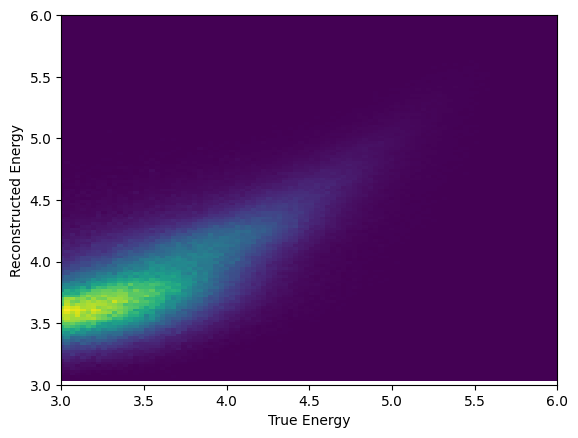

In [7]:
# visualize the reco energy and true energy relation
plt.hist2d(true_log_E, reco_energy, bins = 150, weights = weights)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [8]:
particle_ids = {1:0, 14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [9]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)

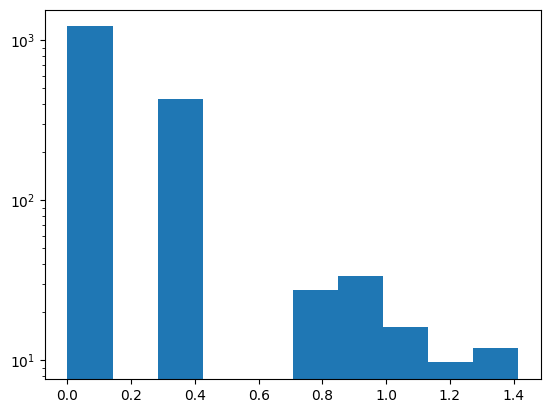

In [10]:
plt.hist(np.log10(atomic_number), weights = weights)
plt.yscale('log')
plt.show()

In [11]:
mean_logz = np.average(np.log10(atomic_number), weights = weights)
mean_logz

0.12907633785790856

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [12]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [19]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [21]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

In [ ]:
mean_energies = []
mean_atomic = []

for cut in cuts:
    mean_energy = np.average(true_log_E[cut], weights = weights[cut])
    mean_logz = np.average(np.log10(atomic_number[cut]), weights = weights[cut])

    mean_energies.append(mean_energy)
    mean_atomic.append(mean_logz)

    bins, edges = np.histogram(np.log10(atomic_number[cut]), weights = weights[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edges[1:], bins, 'b')
    plt.hist()

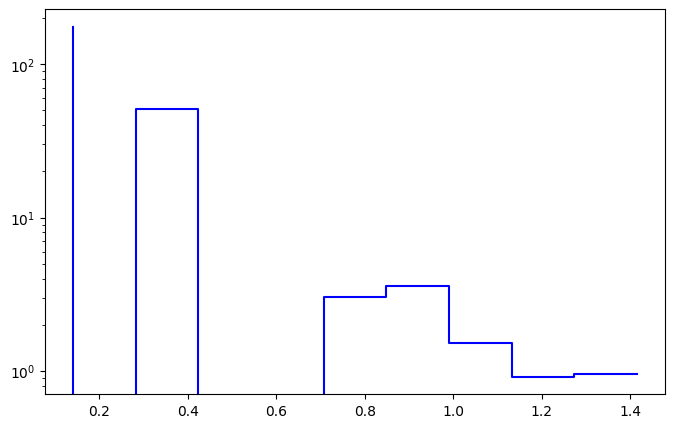

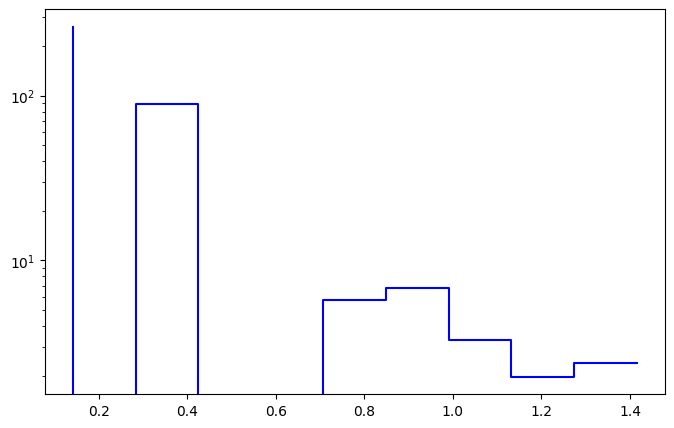

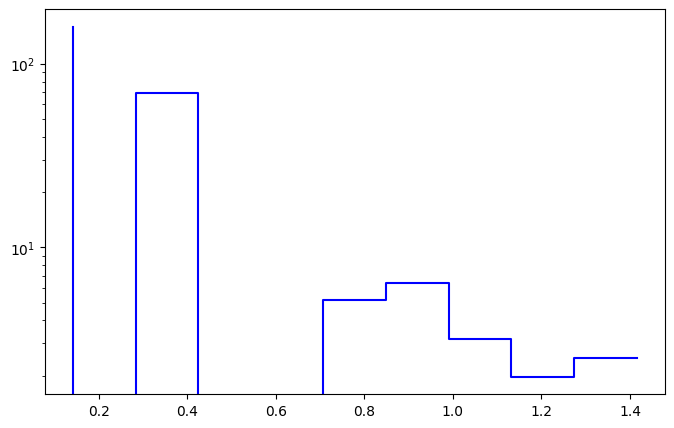

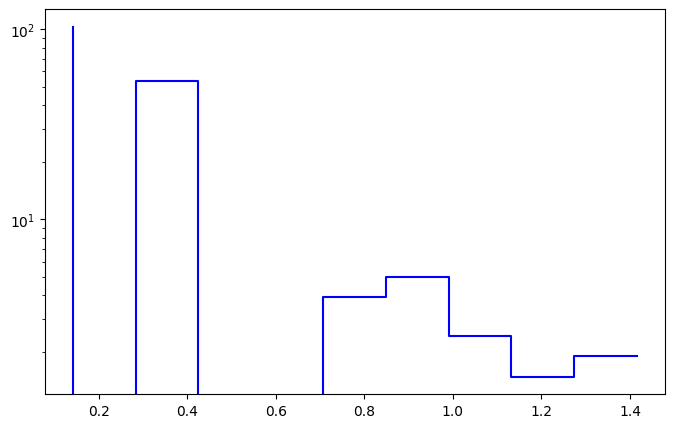

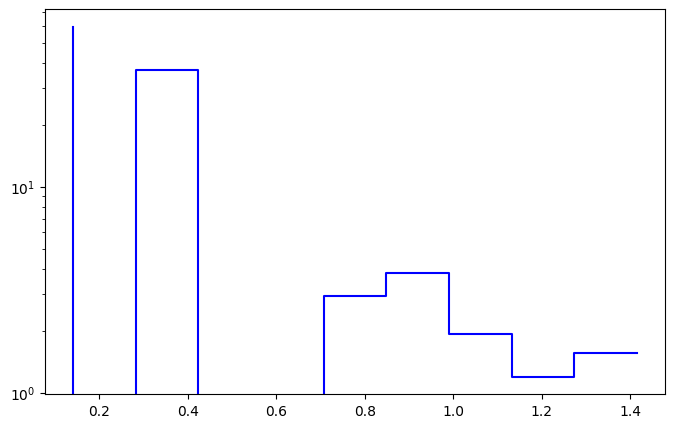

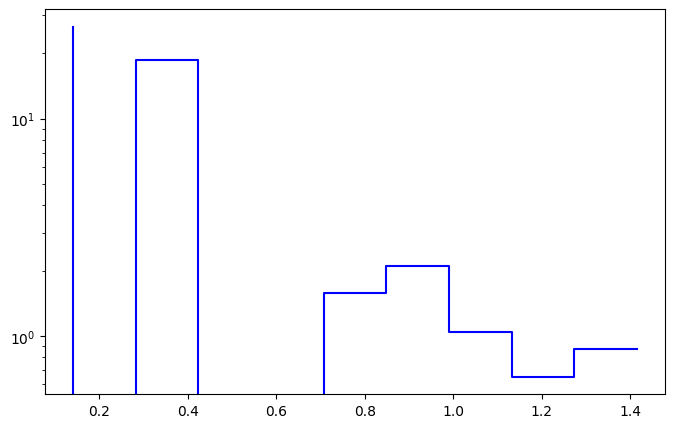

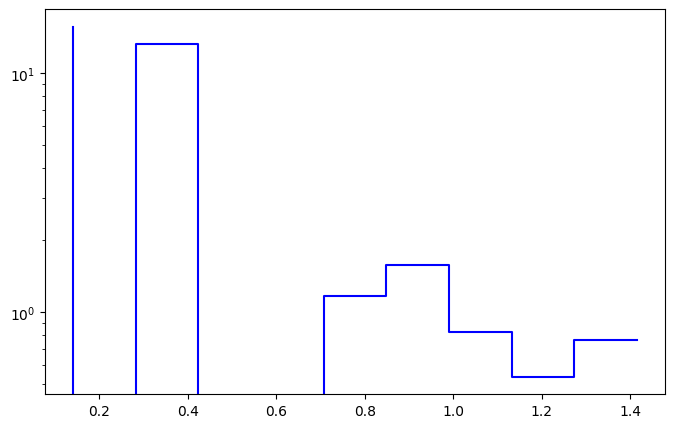

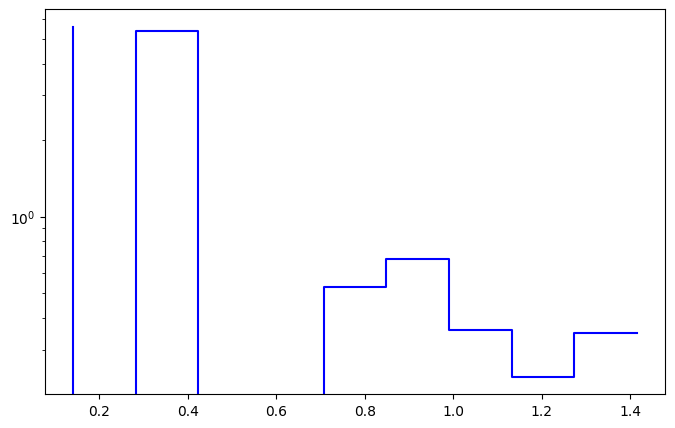

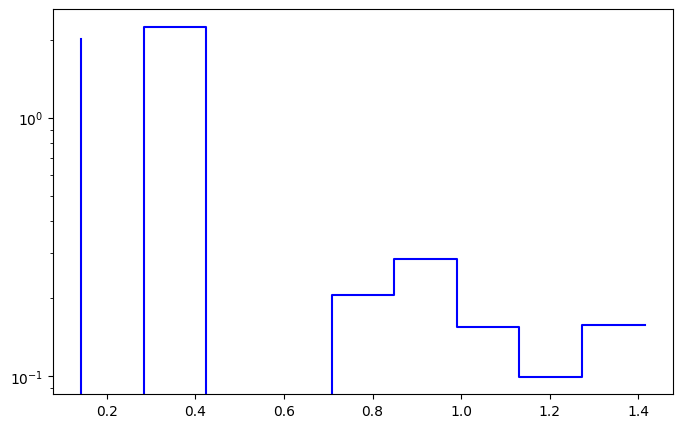

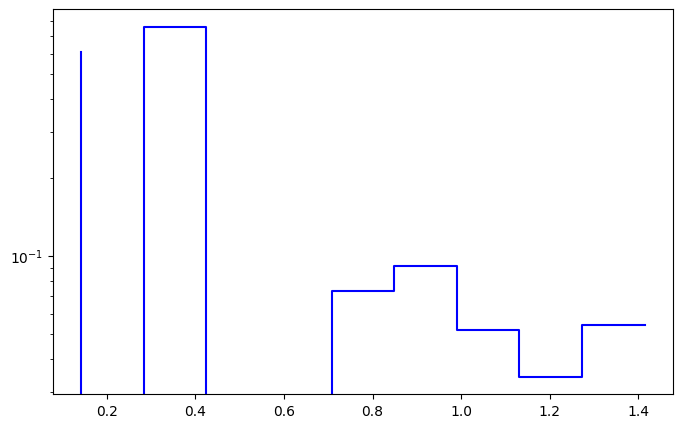

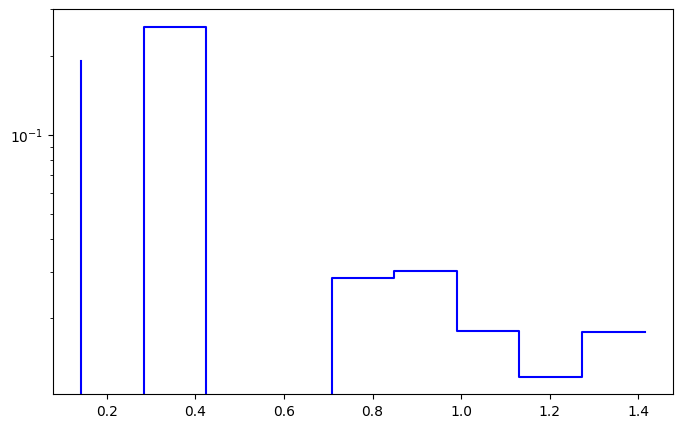

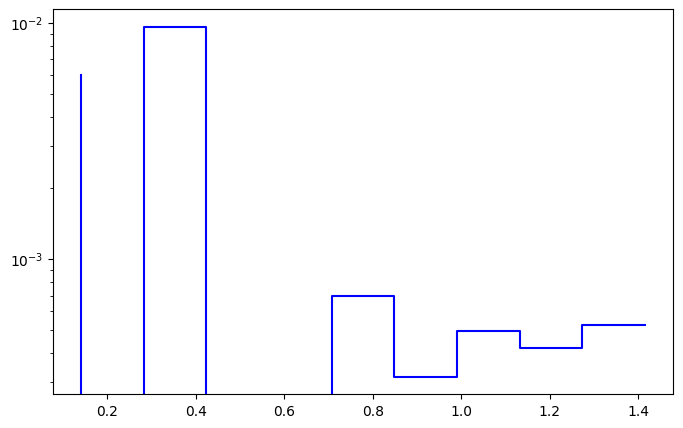

In [17]:
mean_energies = []
mean_atomic = []

for i, j, k in zip(min_energies, max_energies, pinc_vals):

    # define the cut for each energy bin
    cut = np.logical_and(i <= reco_energy, j > reco_energy)
    cut = np.logical_and(cut, pinc > k)

    # apply the cut
    energy = true_log_E[cut]
    weight = weights[cut]

    # calculate mean true energy and mean atomic number
    mean_energy = np.average(energy ,weights = weight)
    mean_logz = np.average(np.log10(atomic_number[cut]), weights = weight)

    # add it to the array
    mean_energies.append(mean_energy)
    mean_atomic.append(mean_logz)
    
    # visualize the cuts
    bins, edges = np.histogram(np.log10(atomic_number[cut]), weights = weight)
    plt.figure(figsize=(8,5))
    plt.step(edges[1:], bins, 'b')
    plt.yscale('log')
    plt.show()


mean_energies = np.array(mean_energies)
mean_atomic = np.array(mean_atomic)

In [18]:
total_n, total_edges = np.histogram(true_log_E, bins = mean_energies, weights = weights)

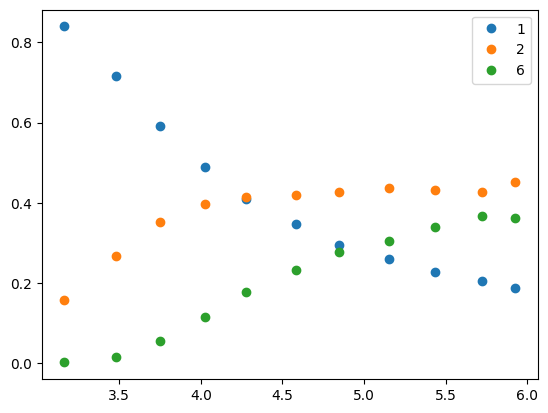

In [59]:
for i in np.unique(atomic_number):
# for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(true_log_E_5[atomic_number >= i], bins = mean_energies, weights = weights_5[atomic_number >= i])
    else:
        ni, ei = np.histogram(true_log_E_5[atomic_number == i], bins = mean_energies, weights = weights_5[atomic_number == i])

    frac = ni/total_n
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.legend()
    

In [37]:
mean_rid = mean_energies - mean_atomic

In [38]:
mean_rid

array([2.81319335, 3.03805136, 3.31701688, 3.56938584, 3.81972972,
       4.04497774, 4.321194  , 4.55818786, 4.8450964 , 5.10989772,
       5.38700835, 5.62348182])

In [34]:
mean_energies

array([2.91869148, 3.16320496, 3.47792446, 3.74814745, 4.02750556,
       4.27486114, 4.58400455, 4.84669774, 5.15354203, 5.43174198,
       5.71936078, 5.9254539 ])

In [35]:
mean_atomic

array([0.10549812, 0.1251536 , 0.16090758, 0.1787616 , 0.20777584,
       0.2298834 , 0.26281055, 0.28850988, 0.30844563, 0.32184426,
       0.33235244, 0.30197208])

In [39]:
print(np.power(10, mean_atomic))

[1.27496459 1.33399316 1.44846359 1.50925146 1.61352552 1.69778779
 1.8315153  1.94316591 2.03444349 2.09818732 2.14957418 2.00434315]


# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- isgoodllh: 
- ndir: 
- ldir:
- rlogl:
- atmosphere:
- TriggID_1006:
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [5]:
dst = np.load('dst_20904.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'reco_energy']


In [6]:
print(dst['llhZen'])

[59.91381836 34.987854   57.38016129 ... 43.52651596 41.71209335
 59.78440094]


In [7]:
print(np.unique(dst['type']))

[      2212 1000020040 1000070140 1000130270 1000260560]


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

In [9]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = dst['energy'][imain_cut]
weights_1 = dst['GaisserH3a'][imain_cut]
weights_2 = dst['Hoerandel'][imain_cut]
weights_3 = dst['GlobalFitGST'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]

iparticle_ids = {2212: 0, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}